<h1 align=center><font size = 5>Final Project Kelompok 9 DBA A5</font></h1>
<h1 align=center><font size = 5>Studi Independen Kampus Merdeka x Ruangguru</font></h1>
<h1 align=center><font size = 5>Time-series & Forecasting</font></h1>

## Importing Libraries

In [1]:
!pip install fbprophet

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

from fbprophet import Prophet
from matplotlib.pylab import rcParams
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

## Upload Dataset
Data yang disajikan merupakan data penjualan atau sales pada sebuah ritel ternama di Brazil yang memiliki banyak Stock Keeping Unit(SKU) dan memiliki banyak cabang.

In [2]:
# Disini kita ingin menampilkan data yang diperoleh dan membuat indexnya menjadi datetime

df=pd.read_csv('/content/mock_kaggle.csv',header=0, index_col=0, parse_dates=True)
df

,venda,estoque,preco
data,,,
2014-01-01,0,4972,1.29
2014-01-02,70,4902,1.29
2014-01-03,59,4843,1.29
2014-01-04,93,4750,1.29
2014-01-05,96,4654,1.29
...,...,...,...
2016-07-27,98,3179,2.39
2016-07-28,108,3071,2.39
2016-07-29,128,4095,2.39


Nama variabel pada masing masing kolom masih menggunakan bahasa Brazil sehingga diperlukan untuk mengubah nama kolom agar mempermudah pemahaman data.

Nama kolom yang akan dirubah adalah :


1.   Kolom 'venda'   = diubah menjadi 'sales'
2.   Kolom 'estoque' = diubah menjadi 'stock'
3.   Kolom 'preco'   = diubah menjadi 'price'



In [3]:
# Mengubah nama columns pada dataset
data = df.rename(columns={'venda':'sales', 'estoque':'stock', 'preco':'price'}, inplace=False)

data.head()

,sales,stock,price
data,,,
2014-01-01,0,4972,1.29
2014-01-02,70,4902,1.29
2014-01-03,59,4843,1.29
2014-01-04,93,4750,1.29
2014-01-05,96,4654,1.29


Pada kasus ini kita akan menganalisa data penjualan dari salah satu retail di Brazil menggunakan metode time series forecasting. Sehingga kita hanya membutuhkan data penjualan ['sales'] dan tanggal penjualan ['date'].

Untuk mempermudah proses penggolahan data dapat dilakukan *drop* data yang tidak diperlukan, yaitu ['stock'] dan ['price']

In [4]:
# Drop columns yang tidak digunakan
data = data.drop(columns=['stock','price'])

data

,sales
data,
2014-01-01,0
2014-01-02,70
2014-01-03,59
2014-01-04,93
2014-01-05,96
...,...
2016-07-27,98
2016-07-28,108
2016-07-29,128


## Data Exploration
Pada tahap ini digunakan untuk memahami dan memperoleh pengetahuan lebih banyak tentang data yang akan digunakan, dimana data historikal hanya meliputi data penjualan setiap harinya sejak 1 Januari 2014 hingga 31 Juli 2016.

In [5]:
# Melihat summary dari data
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 937 entries, 2014-01-01 to 2016-07-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   sales   937 non-null    int64
dtypes: int64(1)
memory usage: 14.6 KB


In [6]:
# Mengecek apakah terdapat missing value

data.isnull().sum()

sales    0
dtype: int64

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
sales,937.0,90.533618,80.682089,0.0,33.0,76.0,127.0,542.0


#Data Analysis
Pada tahap ini kita akan menganalisa data agar siap untuk dimasukkan ke dalam model, karena pada kasus kali ini adalah data timeseries, maka kita perlu mengecek persyaratan data timeseries yaitu stasioneritas, apakah data yang kita pakai ini sudah stasioner atau belum dan jika belum bagaimana kita akan menstasionerkannya.

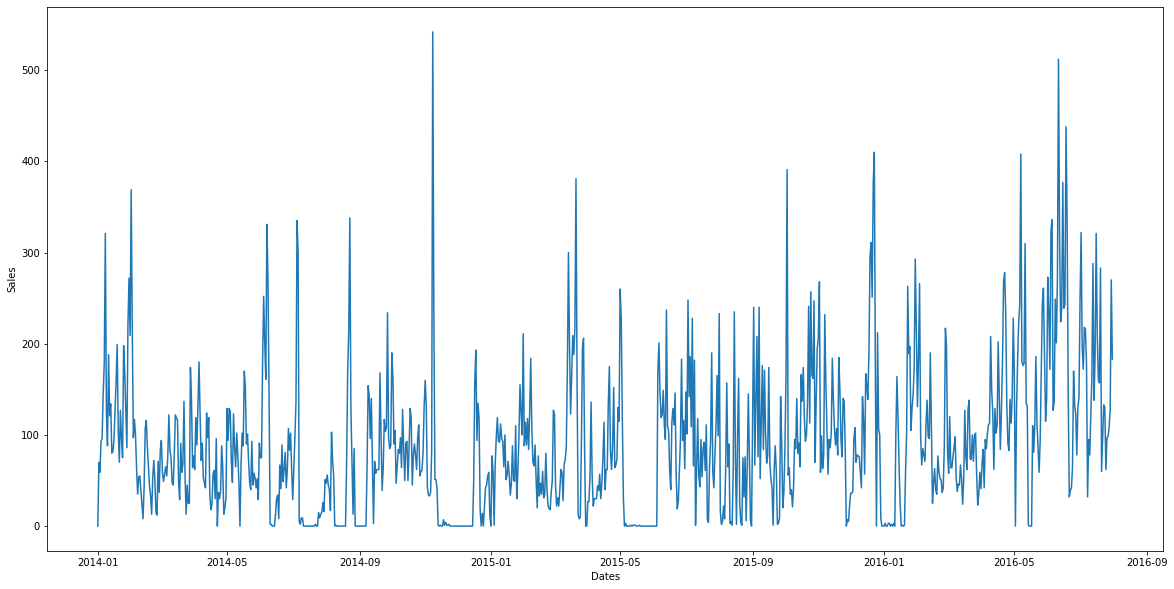

In [8]:
plt.figure(figsize=(20,10))
plt.xlabel("Dates")
plt.ylabel("Sales")
plt.plot(data)

Pada modeling menggunakan time series forecasting penting untuk memastikan bahwa data yang digunakan bersifat stasioner. Sehingga kita harus melakukan pengecekan stasioneritas data. Pada kasus ini akan dilakukan pengecekan stasioneritas menggunakan : 

1.   Rolling Statistic test
2.   Augmented Dickey-Fuller (ADF) test



## Stationarity Check - Rolling Statistic test

In [9]:
rolmean = data.rolling(window=12).mean()
rolstd  = data.rolling(window=12).std()
print(rolmean.head(15))
print(rolstd.head(15))

                 sales
data                  
2014-01-01         NaN
2014-01-02         NaN
2014-01-03         NaN
2014-01-04         NaN
2014-01-05         NaN
2014-01-06         NaN
2014-01-07         NaN
2014-01-08         NaN
2014-01-09         NaN
2014-01-10         NaN
2014-01-11         NaN
2014-01-12  123.750000
2014-01-13  134.916667
2014-01-14  135.750000
2014-01-15  137.666667
                sales
data                 
2014-01-01        NaN
2014-01-02        NaN
2014-01-03        NaN
2014-01-04        NaN
2014-01-05        NaN
2014-01-06        NaN
2014-01-07        NaN
2014-01-08        NaN
2014-01-09        NaN
2014-01-10        NaN
2014-01-11        NaN
2014-01-12  80.869283
2014-01-13  70.860244
2014-01-14  70.081933
2014-01-15  68.077941


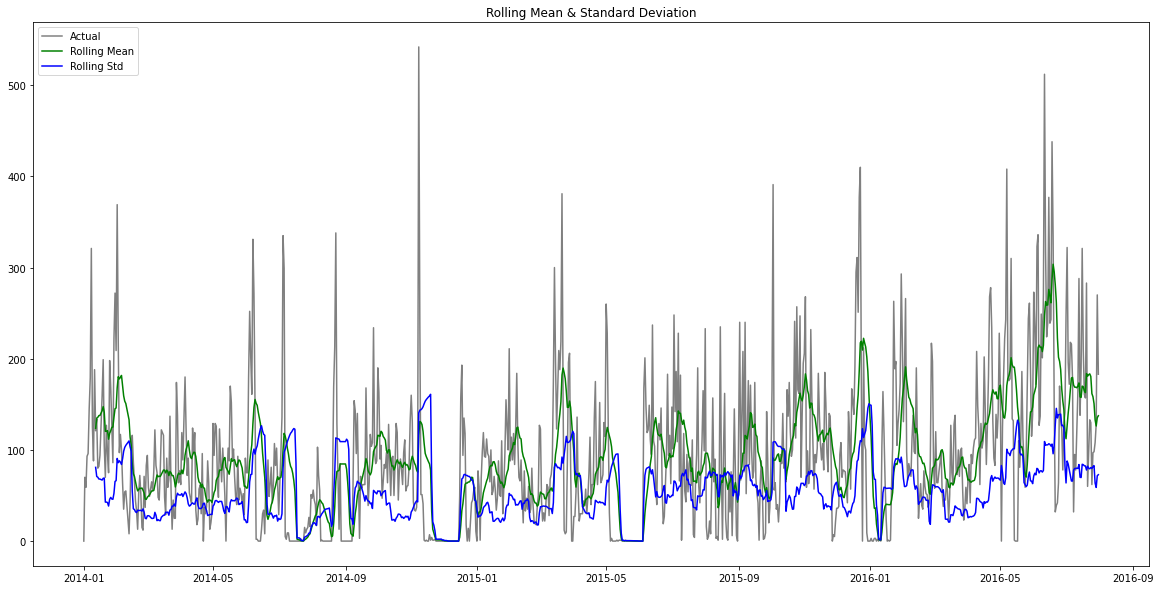

In [10]:
plt.figure(figsize=(20,10))
actual = plt.plot(data, color='grey', label='Actual')
mean_6 = plt.plot(rolmean, color='green', label='Rolling Mean') 
std_6  = plt.plot(rolstd, color='blue', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

## Stationarity Check - Augmented Dickey-Fuller (ADF) test

In [11]:
from statsmodels.tsa.stattools import adfuller
print('Dickey-Fuller Test: ')
dftest   = adfuller(data['sales'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Dickey-Fuller Test: 
Test Statistic           -5.326902
p-value                   0.000005
Lags Used                14.000000
No. of Obs              922.000000
Critical Value (1%)      -3.437462
Critical Value (5%)      -2.864680
Critical Value (10%)     -2.568442
dtype: float64


Mengecek stasioneritas dari data menggunakan ADF dapat dilihat bahwa hasil ADF statistics nilainya lebih kecil serta nilai p-value yang lebih kecil dibandingkan dengan semua critical value pada confidence level 1%,5%,10%, menandakan bahwa berhasil menolak null hypothesis dan menunjukkan bahwa data tersebut stasioner.
Karena datanya sudah stasioner maka kita dapat langsung memasukkannya ke dalam model yang akan digunakan

# Model Development

## Best Model check with AIC and BIC

In [14]:
!pip install statsmodels
import statsmodels.api as sm
order_aic_bic=[]
for p in range(3):
  for q in range(3):
    model=sm.tsa.statespace.SARIMAX(data, order=(p,0,q))
    results=model.fit()
    order_aic_bic.append((p,q,results.aic,results.bic))
order_df=pd.DataFrame(order_aic_bic,columns=['p','q','aic','bic'])
print(order_df.sort_values('aic'))
print(order_df.sort_values('bic'))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

   p  q           aic           bic
7  2  1  10373.218440  10392.589173
8  2  2  10375.176896  10399.390312
5  1  2  10398.014596  10417.385329
4  1  1  10457.135876  10471.663926
6  2  0  10475.119313  10489.647363
3  1  0  10489.904940  10499.590307
2  0  2  10795.595746  10810.123796
1  0  1  11024.001682  11033.687049
0  0  0  11652.106117  11656.948801
   p  q           aic           bic
7  2  1  10373.218440  10392.589173
8  2  2  10375.176896  10399.390312
5  1  2  10398.014596  10417.385329
4  1  1  10457.135876  10471.663926
6  2  0  10475.119313  10489.647363
3  1  0  10489.904940  10499.590307
2  0  2  10795.595746  10810.123796
1  0  1  11024.001682  11033.687049
0  0  0  11652.106117  11656.948801


Pada kasus kali ini akan digunakan model time series forecasting menggunakan metode ARIMA. Hal tersebut didasarkan pada data yang tidak memiliki kondisi seasonality.

Metode ARIMA yang akan digunakan adalah *Out-of-Time Cross validation*. Pengunaan model tersebut bertujuan untuk melakukan forecasting pada data masa depan dan membandingkannya dengan data aktual yang dimiliki.

Pada Metodde tersebut kita perlu menentukan terlebih dahulu nilai dari : 
1.   Nilai p yang digunakan untuk AR term
2.   Nilai q yang digunakan untuk MA term
3.   Nilai d merupakan *diffrencing* untuk menstasionerkan data

**Nilai Differencing (d)**

Digunakan untuk menstasinerkan data. Penentuan nilai d didasarkan pada nilai P value pada uji *Augmented Dickey Fuller test*. Apabila nilai P Value < 0.05 maka dapat disimpulkan bahwa data bersifat stasioner dan tidak perlu dilakukan differencing atau nilai d = 0.

Hasil dari uji Augmented Dickey-Fuller (ADF) test yang sebelumnya telah dilakukan, diperoleh nilai P value = 0.000005 < 0,05. Sehingga nilai d yang digunakan adalah 0.

Text(0.5, 1.0, 'Partial Autocorrelation Function / PACF')

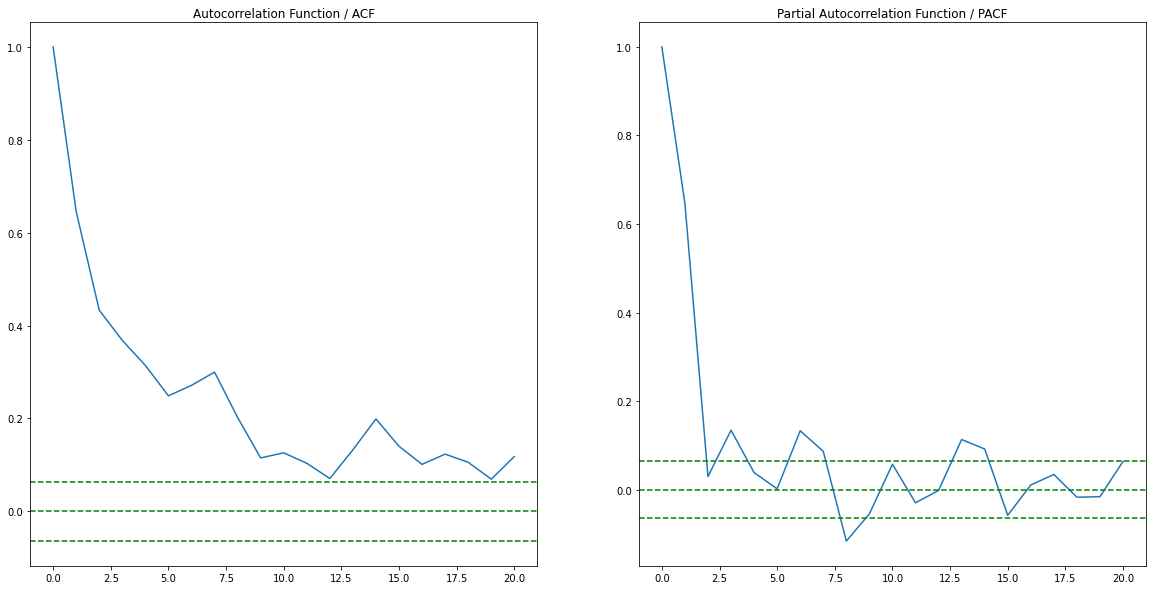

In [15]:
# ACF = Auto Correlation Function
# PACF = Partial Auto Correlation Function
from statsmodels.tsa.stattools import acf, pacf 

# terapkan function acf dan pcf pada data_shift yang sudah dibuat
lag_acf=acf(data, nlags=20)
lag_pacf=pacf(data, nlags=20, method='ols')

# Format grafik dan visualisasikan ACF
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(data)),linestyle='--',color='green') # y = -0.16
plt.axhline(y=1.96/np.sqrt(len(data)),linestyle='--',color='green') # y = 0.16
plt.title('Autocorrelation Function / ACF')

# Format grafik dan visualisasikan PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(data)),linestyle='--',color='green') # y = -0.16
plt.axhline(y=1.96/np.sqrt(len(data)),linestyle='--',color='green') # y = 0.16
plt.title('Partial Autocorrelation Function / PACF')

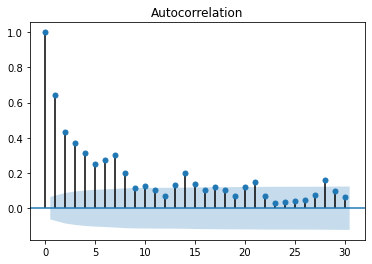

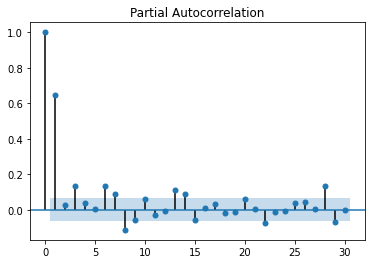

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
data.iloc[0] = 0
plot_acf(data)
plot_pacf(data)
plt.show()

**Nilai MA Term (q)**

Nilai MA term (q) merupakan *the error of the lagged forecast* yang didasarkan pada *Auto Correlation Function* (ACF). ACF menunjukkan 

Pada grafik di atas dapat dilihat bahwa nilai autocorrelation tidak memotong / melewati garis putus-putus sehingga dapat diartikan bahwa specific lag tidak berkorelasi secara signifikan dengan time series yang ada. Karena nilai 



**Nilai AR Term (p)**

Nilai AR term (p) didasarkan pada *Partial Autocorrelation* (PACF). Pada hasil grafik di atas diperoleh kesimpulan bahwa terjadi autocorrelation pada model Partial Autocorrelation. Sehingga kita pelru memberikan lag pada AR term. pada kasus ini nilai p = 1

## Modeling ARIMA

In [17]:
from statsmodels.tsa.arima_model import ARIMA

# ARIMA Model
model = ARIMA(data.sales, order=(2,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  sales   No. Observations:                  937
Model:                     ARMA(2, 1)   Log Likelihood               -5180.519
Method:                       css-mle   S.D. of innovations             60.912
Date:                Sat, 07 May 2022   AIC                          10371.038
Time:                        14:11:41   BIC                          10395.251
Sample:                             0   HQIC                         10380.269
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          96.6585     19.181      5.039      0.000      59.065     134.252
ar.L1.sales     1.5647      0.055     28.437      0.000       1.457       1.673
ar.L2.sales    -0.5688      0.049    -11.729    

Hasil dari pemodelan ARIMA yang digunakan dengan menggunakan nilai p, d, q = 1, 0, 0 menunjukkan hasil P Value AR term 1 < 0.01. Artinya model yang digunakan telah signifikan.

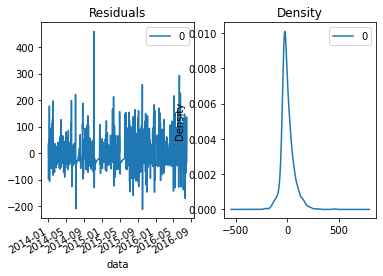

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Dari hasil plot di atas menunjukkan bahwa nilai residual errors yang cukup baik dimana nilai rata ratanya tersebar di antara nilai 0.

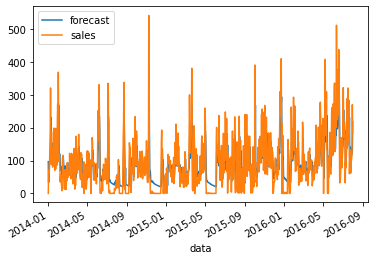

In [18]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

Hasil pemodelan Arima yang digunakan telah menunjukkan hasil yang cukup baik. Dimana hasil forecas menggunakan model ARIMA terdistribusi mendekati nilai aktualnya yaitu sales.

Hasil Modeling diatas hanya menunjukkan hasil modeling ARIMA terhadap data di yang ada. Sehingga untuk menguji model untuk melakukan forecasting perlu dilakukan modeling menggunakan metode ARIMA Out-of-Time Cross validation.

## Modeling ARIMA Out-of-Time Cross validation

Langkah peetama perlu dilakukan pembagian data yang digunakan untuk training dan juga testing model dengan komposisi pembagian adah 80% untuk training dan 20% data untuk testing

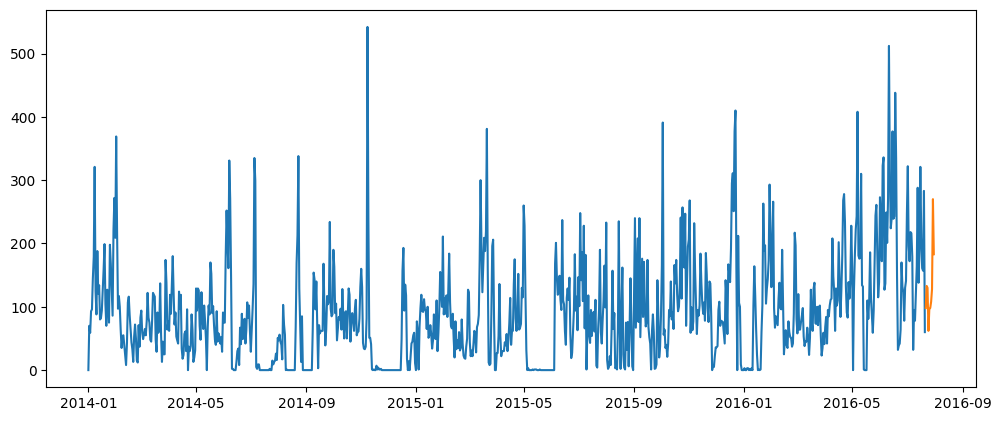

In [29]:
# Split data yang dimiliki menjadi 2 bagian yaitu :
train = data[0:int(len(data)*0.99)]    #train data sebesar 99%
test  = data[int(len(data)*0.99):]     #test data sebesar 1%
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train)
plt.plot(test)

Menggunakan model ARIMA sebelumnya dimasukkan kedalam model ARIMA Out-of-Time Cross validation.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  sales   No. Observations:                  927
Model:                     ARMA(2, 1)   Log Likelihood               -5126.669
Method:                       css-mle   S.D. of innovations             61.007
Date:                Sat, 07 May 2022   AIC                          10263.338
Time:                        14:19:40   BIC                          10287.498
Sample:                             0   HQIC                         10272.554
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          95.9082     19.491      4.921      0.000      57.706     134.110
ar.L1.sales     1.5620      0.064     24.496      0.000       1.437       1.687
ar.L2.sales    -0.5667      0.055    -10.295    

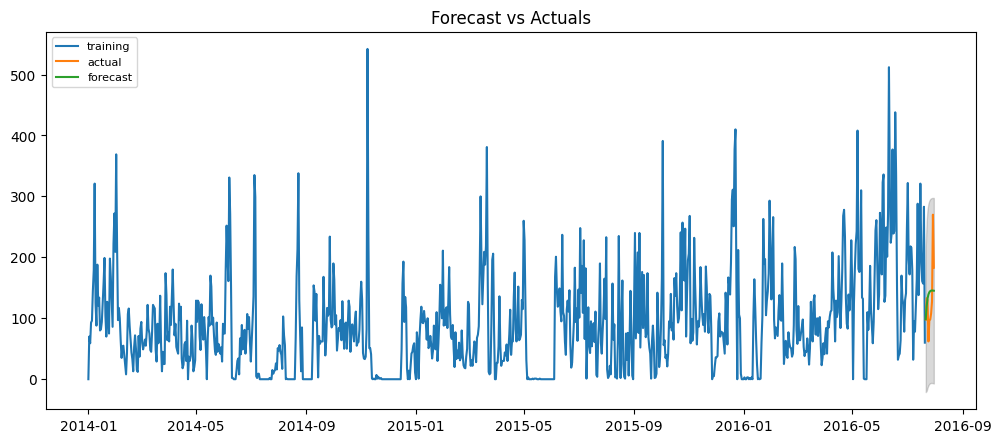

In [31]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train, order=(2,0,1))  
fitted = model.fit()  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(10, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Hasil dari forecasting ARIMA Out-of-Time Cross validation menunjukkan hasil dimana grafik forecasting menunjukkan adanya penurunan sales. Hal tersebut juga selaras dengan data aktual sales yang menunjukkan terjadinya tren penurunan pada awal data test. Akan tetapi setelah terjadinya penurunan grafik menunjukkan hasil forecasting yang mendatar. Hal tersebut disebabkan karena ARIMA memiliki keunggulan untuk digunakan pada forecasting jangka pendek dan memiliki kecenderungan konstan pada periode jangka panjang. 

# Model Evaluation

In [32]:
y_pred=pd.Series(fitted.forecast(188)[0], index=data.sales[749:].index)
y_true=data.sales[749:]

def forecast_accuracy(y_pred,y_true):
  mape=np.mean(np.abs(y_pred-y_true)/np.abs(y_true))
  mae=np.mean(np.abs(y_pred-y_true))
  mse=np.mean((y_pred-y_true)/y_true)
  rmse=np.mean((y_pred-y_true)**2)**.5

  return({'mape':mape, 'mae': mae,
          'mse': mse, 'rmse':rmse})

forecast_accuracy(fc, test.values)

{'mae': 44.17197945657409,
 'mape': 0.3720152245755195,
 'mse': 0.1999781801728782,
 'rmse': 57.52699776613234}

# Deployment

Hasil forecasting model menggunakan arima menunjukkan hasil grafik forecasting yang mengalami penurunan pada awal forecasting. Hal tersebut juga didukung dengan adanya tren penurunan data aktual. Model ARIMA yang digunakan memang mampu melakukan forecasting pada periode jangka waktu yang pendek namun menghasilkan nilai konstan pada jangka panjang.

Dari hasil modeling menggunakan ARIMA tersebut maka dapat diambil kesimpulan bahwa perusahaan retail tersebut akan menghadapi kondisi penurunan jumlah sales pada jangka waktu dekat. Sehingga pihak stakeholder retail tersebut perlu untuk segera membuat keputusan bisnis dalam jangka waktu dekat untuk menghindari atau meminimalisir terjadinya penurunan sales dalam jangka waktu yang dekat.

#Forecasting Model with FBPROPHET

In [ ]:
df=pd.read_csv('/content/mock_kaggle.csv')
df

,data,venda,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29
...,...,...,...,...
932,2016-07-27,98,3179,2.39
933,2016-07-28,108,3071,2.39
934,2016-07-29,128,4095,2.39
935,2016-07-30,270,3825,2.39


In [ ]:
sales_sample=data.rename(columns={'data':'ds', 'sales':'y'})
sales_sample

,ds,y
0,2014-01-01,0
1,2014-01-02,70
2,2014-01-03,59
3,2014-01-04,93
4,2014-01-05,96
...,...,...
932,2016-07-27,98
933,2016-07-28,108
934,2016-07-29,128
935,2016-07-30,270


In [ ]:
m = Prophet()
m.fit(sales_sample)
# Forcasting into the future
future = m.make_future_dataframe(periods=1000)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


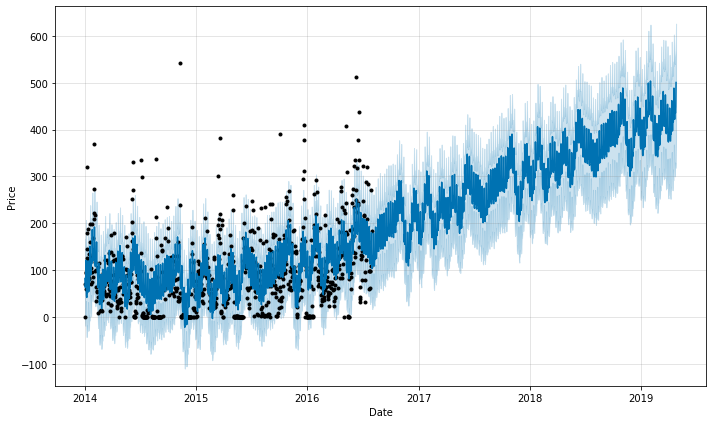

In [ ]:
figure=m.plot(forecast, xlabel='Date', ylabel='Price')

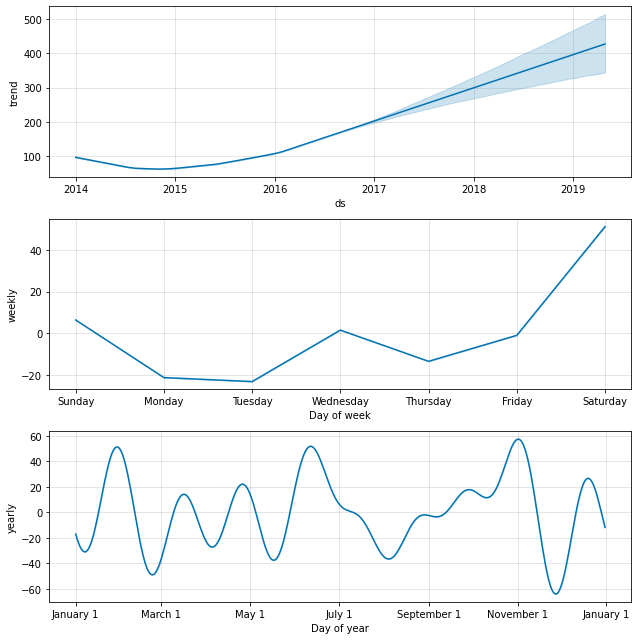

In [ ]:
figure3 = m.plot_components(forecast)